In [1]:
import pickle 
with open('../MCGenerator/clustering_results/narrasum/results/clustered_mcs_topthreeprompts_run2.pickle', 'rb') as f:
    mcs_per_stimuli = pickle.load(f)

In [28]:
narrasum_dataset = load_jsonl('../data/narrasum/narrasum_sampled_data_with_decomposed_mcs_gpt4.jsonl')

gold_concepts_dict = {}
for idx, d in enumerate(narrasum_dataset):
    gold_concepts_dict[idx] = d['decomposed_summary_sentences_gpt4']

In [2]:
from openai import OpenAI
import os
os.environ["OPENAI_API_KEY"] = 'api-key'
client = OpenAI()

def get_response(prompt):
    response = client.chat.completions.create(
      model="gpt-4o",
      messages=[
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": prompt
            }
          ]
        }
      ],
      temperature=0.0,
      max_tokens=2048,
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0,
      response_format={
        "type": "text"
      }
    )
    return response.choices[0].message.content


def construct_prompt(gold_concepts: dict, generated_concepts_str: str) -> str:
    '''Construct a prompt asking if each gold concept is present in the generated concepts (to eval recall)'''
    gold_concept_str = ''
    for n, concept in gold_concepts.items():
        gold_concept_str += f"{n}. {concept}\n"
      
    prompt = f"""First, I will give you a list of main concepts. Then, I will give you a numbered list of candidate concepts. For each candidate concept, indicate whether it is supported by the list of main concepts. If it is supported, provide the span of text from the main concepts that support your answer; otherwise, provide an explanation of why it is not supported. Based on your explanation, predict “yes” or “no” for each candidate concept. Output your response by numbering the candidate concepts in the order they are presented.
Provide output in the following format exactly:
[
{{"MC": 1, "span": "explanation", "is_supported": "yes" or "no"}},
{{"MC": 2, "span": "explanation", "is_supported": "yes" or "no"}},
...
]

Main Concepts:
{generated_concepts_str}

Candidate Concepts:
{gold_concept_str}

Only provide the output in the specified format and nothing else (e.g., introductory texts, explanations, or reasons).
"""
    return prompt

def parse_llm_eval(response: str, gold_concepts: dict) -> dict:
    parse_error = False
    cleaned_resp = response.strip('```json').strip('```').strip()
    try:
        parsed_resp = json.loads(cleaned_resp)
        gold_concepts_coverage = {
            item["MC"]: 1 if item["is_supported"] == "yes" else 0
            for item in parsed_resp
        }
        
    except:
        
        gold_concepts_coverage = {
            item: 0 for item in range(len(gold_concepts))
        }
        parse_error = True
        
    if len(gold_concepts_coverage) < len(gold_concepts):
        full_coverage = {i: 0 for i in range(len(gold_concepts))}
        full_coverage.update(gold_concepts_coverage)
        gold_concepts_coverage = full_coverage
        
    assert len(gold_concepts_coverage) == len(gold_concepts), f"Response does not cover all gold concepts: {gold_concepts_coverage} {gold_concepts}"
    
    return gold_concepts_coverage, parse_error

def get_yield(sentences):
    num_toks = 0
    for s in sentences:
        num_toks+=len(s.split())
    return num_toks

In [ ]:
import tiktoken
import pickle 
encoding = tiktoken.encoding_for_model("gpt-4")

def num_tokens_from_string(string, encoding):
    """Returns the number of tokens in a text string."""
    num_tokens = len(encoding.encode(string))
    return num_tokens

results = {}
prompt_tokens = []
output_tokens = []

for stimuli in tqdm(np.arange(100)):
    gcs = {k:v for k, v in enumerate(gold_concepts[stimuli])}
    mcs_per_delta = mcs_per_stimuli[stimuli]
    
    results[stimuli] = {}
    for delta in mcs_per_delta:
        mc_representatives = mcs_per_delta[delta]['closest_examples']

        eval_prompt = construct_prompt(gcs, "\n".join(mc_representatives))
        
        response = get_response(eval_prompt)

        gold_coverage, parse_error = parse_llm_eval(response, gcs)
        recall = sum(gold_coverage.values()) / len(gold_coverage)

        results[stimuli][delta] = {'recall':recall,\
                                   'gold_coverage': gold_coverage,\
                                   'mc_representatives': mc_representatives,\
                                   'eval_prompt': eval_prompt,\
                                   'gold_concepts': gcs,\
                                   'response': response,\
                                   'yield_num_toks':get_yield(mc_representatives),\
                                   'yield_num_mcs':len(mc_representatives),\
                                   'parse_error': parse_error
                                  }
        
        prompt_tokens.append(num_tokens_from_string(eval_prompt, encoding))
        output_tokens.append(num_tokens_from_string(response, encoding))
        
        
        with open('../MCGenerator/clustering_results/narrasum/results/clustered_mcs_topthreeprompts_run2_evaluated.pickle', 'wb') as f:
            pickle.dump(results, f)

In [3]:
import pickle 

with open('../MCGenerator/clustering_results/narrasum/results/clustered_mcs_topthreeprompts_run2_evaluated.pickle', 'rb') as f:
    results = pickle.load(f)

In [4]:
from collections import defaultdict
delta_values = defaultdict(lambda: {'recall': 0, 'yield_num_toks': 0, 'yield_num_mcs': 0, 'count': 0})

for stimuli in results:
    for delta, metrics in results[stimuli].items():
        delta_values[delta]['recall'] += metrics['recall']
        delta_values[delta]['yield_num_toks'] += metrics['yield_num_toks']
        delta_values[delta]['yield_num_mcs'] += metrics['yield_num_mcs']
        delta_values[delta]['count'] += 1

averaged_results = {delta: {
    'avg_recall': vals['recall'] / vals['count'],
    'avg_yield_num_toks': vals['yield_num_toks'] / vals['count'],
    'avg_yield_num_mcs': vals['yield_num_mcs'] / vals['count'],
} for delta, vals in delta_values.items()}


sorted_deltas = sorted(averaged_results.keys())
avg_recall = [averaged_results[delta]['avg_recall'] for delta in sorted_deltas]
avg_yield_num_toks = [averaged_results[delta]['avg_yield_num_toks'] for delta in sorted_deltas]
avg_yield_num_mcs = [averaged_results[delta]['avg_yield_num_mcs'] for delta in sorted_deltas]


In [ ]:
bounds = {}
bounds['help w/ decomp'] = {'recall': 0.46, 'yield_num_toks': 307.91}
bounds['5Ws w/ decomp'] = {'recall': 0.46, 'yield_num_toks': 232.31}
bounds['5finger w/ decomp'] = {'recall': 0.46, 'yield_num_toks': 247.87}
bounds['empirical union w/ decomp'] = {'recall': 0.64, 'yield_num_toks': 3953.10}
bounds['theoretical union w/ decomp'] = {'recall': 0.87, 'yield_num_toks': 3953.10}

In [8]:
import pandas as pd
df = pd.DataFrame()
df['experiment'] = ['clustering']*len(sorted_deltas)
df['delta'] = sorted_deltas
df['avg_yield_num_toks'] = avg_yield_num_toks
df['avg_recall'] = avg_recall

for b in bounds:
    new_row = {'experiment': b,\
              'delta': 'n/a',\
              'avg_yield_num_toks': bounds[b]['yield_num_toks'],\
              'avg_recall': bounds[b]['recall']}
    
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    
    
deltas_to_plot = [0, 0.2, 0.4, 0.6, 0.8, 1, 2, 3, 4]
deltas_to_plot = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4]
df = df[df.delta.isin(deltas_to_plot+['n/a'])]
df

#df.to_csv('./clustering_results/narrasum/plots/data_for_plots.csv', sep='\t')

,experiment,delta,avg_yield_num_toks,avg_recall
0,clustering,0.0,2064.67,0.630529
1,clustering,0.1,1840.61,0.654072
2,clustering,0.2,1464.65,0.615974
3,clustering,0.3,1106.39,0.646039
4,clustering,0.4,814.73,0.568319
5,clustering,0.5,569.97,0.530718
6,clustering,0.6,381.18,0.514823
7,clustering,0.7,263.09,0.445350
8,clustering,0.8,185.99,0.447912
9,clustering,0.9,137.93,0.391459


(-200.0, 9000.0)

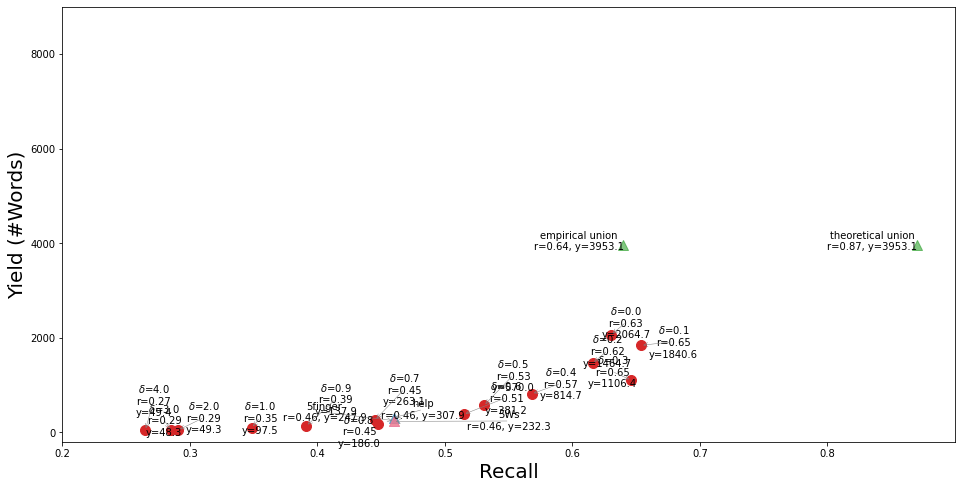

In [11]:
from adjustText import adjust_text
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

def annotate_points(annotations, ax):
    for annotation in annotations:
        annotation.set_fontsize(10)
        annotation.set_ha('right')
        annotation.set_va('bottom')

fig, axes = plt.subplots(1, 1, figsize=(16, 8))

clustering_df = df[df.experiment=='clustering']
axes.scatter(clustering_df.avg_recall, clustering_df.avg_yield_num_toks, color='tab:red', s=100, marker='o', label='Main Data')

annotations = []
for idx, row in clustering_df.iterrows():
    annotation_text = f'$\delta$={row["delta"]}\nr={row["avg_recall"]:.2f}\ny={row["avg_yield_num_toks"]:.1f}'
    
    annotations.append(axes.text(row['avg_recall'],\
                                 row['avg_yield_num_toks'],\
                                 annotation_text,\
                                 ha='center',\
                                 va='center',\
                                 fontsize=12))

non_clustering_df = df[df.experiment!='clustering']
for idx, row in non_clustering_df.iterrows():
    
    label = row['experiment']
    recall = row["avg_recall"]
    yield_toks = row["avg_yield_num_toks"]

    
    if 'union' in label:
        color = 'tab:green'
    elif 'help' in label:
        color = 'tab:blue' 
    elif '5finger' in label:
        color = 'tab:pink'  
    elif '5Ws' in label:
        color = 'tab:orange'  
        
    if 'w/o' in label:
        marker = 's'
    elif 'w/ ' in label:
        marker = '^'
    else:
        marker = 'x'

    axes.scatter(recall, yield_toks, color=color, s=100, marker=marker, alpha=0.6)

        
    annotation_text = (
        f"{label.split(' w/')[0]}\n"
        f"r={recall:.2f}, y={yield_toks:.1f}"
    )
    
    annotations.append(axes.text(recall, yield_toks, annotation_text, fontsize=11, ha='right'))


annotate_points(annotations, axes)

adjust_text(annotations, 
            ax=axes, 
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
            expand_points=(1.2, 1.2),  
            force_points=(0.1, 0.25)   
)


axes.set_xlabel('Recall', fontsize=20)
axes.set_xticks(ticks = np.arange(0.2, 0.8, 0.1), fontsize=20)
axes.set_ylabel('Yield (#Words)', fontsize=20)


axes.set_ylim(-50, 9000) 
axes.margins(y=0.5)  
axes.set_ylim(bottom=-200)  
